# Text-to-Image Generation with Stable Diffusion and OpenVINO™

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It is trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

General diffusion models are machine learning systems that are trained to denoise random gaussian noise step by step, to get to a sample of interest, such as an image.
Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference. OpenVINO brings capabilities to run model inference on Intel hardware and opens the door to the fantastic world of diffusion models for everyone!

Model capabilities are not limited text-to-image only, it also is able solve additional tasks, for example text-guided image-to-image generation and inpainting. This tutorial also considers how to run text-guided image-to-image generation using Stable Diffusion.


This notebook demonstrates how to convert and run stable diffusion model using OpenVINO. For user experience simplification, we will use  [Hugging Face Optimum](https://huggingface.co/docs/optimum/installation) library accelerated by OpenVINO integration for model conversion and [OpenVINO GenAI API](https://docs.openvino.ai/2024/learn-openvino/llm_inference_guide/genai-guide.html) for model inference.

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/stable-diffusion-text-to-image/stable-diffusion-text-to-image.ipynb" />


#### Table of contents:

- [Prerequisites](#Prerequisites)
- - [Convert model using Optimum-CLI tool](#Convert-model-using-Optimum-CLI-tool)
- [Prepare Inference Pipelines](#Prepare-Inference-Pipelines)
- [Text-to-image pipeline](#Text-to-image-pipeline)
    - [Text-to-Image generation](#Text-to-Image-generation)
    - [Interactive text-to-image demo](#Interactive-text-to-image-demo)
- [Image-to-Image pipeline](#Image-to-Image-pipeline)
    - [Image-to-Image generation](#Image-to-Image-generation)
    - [Interactive image-to-image demo](#Interactive-image-to-image-demo)

### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
import platform

%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "diffusers>=0.30.0" "torch>=2.1"
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"  --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "huggingface-hub>=0.9.1" Pillow opencv-python tqdm "gradio>=4.19"
%pip install -qU "openvino>=2025.0" "openvino_genai>=2025.0" "openvino_tokenizers>=2025.0"

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0"

In [ ]:
# Fetch `notebook_utils` module
import requests
from pathlib import Path

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )

    open("notebook_utils.py", "w").write(r.text)


if not Path("cmd_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py",
    )

    open("cmd_helper.py", "w").write(r.text)

from notebook_utils import download_file, device_widget

if not Path("gradio_helper.py").exists():
    download_file(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-text-to-image/gradio_helper.py")

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("stable-diffusion-text-to-image.ipynb")

## Convert model using Optimum-CLI tool
[back to top ⬆️](#Table-of-contents:)

🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 [Transformers](https://huggingface.co/docs/transformers/index) and [Diffusers](https://huggingface.co/docs/diffusers/index) libraries and OpenVINO to accelerate end-to-end pipelines on Intel architectures. It provides ease-to-use cli interface for exporting models to [OpenVINO Intermediate Representation (IR)](https://docs.openvino.ai/2024/documentation/openvino-ir-format.html) format.

The command bellow demonstrates basic command for model export with `optimum-cli`

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <out_dir>
```

where `--model` argument is model id from HuggingFace Hub or local directory with model (saved using `.save_pretrained` method), `--task ` is one of [supported task](https://huggingface.co/docs/optimum/exporters/task_manager) that exported model should solve. For image generation models, `text-to-image` should be used. If model initialization requires to use remote code, `--trust-remote-code` flag additionally should be passed.
You can also apply fp16, 8-bit or 4-bit weight compression on the Linear, Convolutional and Embedding layers when exporting your model with the CLI by setting `--weight-format` to respectively fp16, int8 or int4. This type of optimization allows to reduce the memory footprint and inference latency.

We will use `optimum_cli` from our helper `cmd_helper.py` that is a wrapper over cli-command.

In [ ]:
from cmd_helper import optimum_cli

MODEL_ID = "prompthero/openjourney"
MODEL_DIR = Path("diffusion_pipeline")


if not MODEL_DIR.exists():
    optimum_cli(MODEL_ID, MODEL_DIR, additional_args={"weight-format": "fp16"})

## Prepare Inference Pipelines
[back to top ⬆️](#Table-of-contents:)

Let us now take a closer look at how the model works in inference by illustrating the logical flow.

![sd-pipeline](https://user-images.githubusercontent.com/29454499/260981188-c112dd0a-5752-4515-adca-8b09bea5d14a.png)

As you can see from the diagram, the only difference between Text-to-Image and text-guided Image-to-Image generation in approach is how initial latent state is generated. In case of Image-to-Image generation, you additionally have an image encoded by VAE encoder mixed with the noise produced by using latent seed, while in Text-to-Image you use only noise as initial latent state.
The stable diffusion model takes both a latent image representation of size $64 \times 64$ and a text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder as an input.

Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, it is recommended to use one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)(you will use it in your pipeline)

Theory on how the scheduler algorithm function works is out of scope for this notebook. Nonetheless, in short, you should remember that you compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, refer to the recommended [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated given number of times (by default 50) to step-by-step retrieve better latent image representations.
When complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

## Text-to-image pipeline
[back to top ⬆️](#Table-of-contents:)

`openvino_genai.Text2ImagePipeline` represents inference pipeline for text-to-image generation. For creation pipeline instance, you should provide directory with converted to OpenVINO model and inference device.

When Stable Diffusion models are exported to the OpenVINO format, they are decomposed into three components that consist of four models combined during inference into the pipeline:

* The text encoder
    * The text-encoder is responsible for transforming the input prompt(for example "a photo of an astronaut riding a horse") into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.
* The U-NET
    * Model predicts the `sample` state for the next step.
* The VAE encoder
    * The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model (used only for image-to-image and inpainting tasks).
* The VAE decoder
    * The decoder transforms the latent representation back into an image.

Select device from dropdown list for running inference using OpenVINO.

In [4]:
device = device_widget()
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [5]:
import openvino_genai as ov_genai
from PIL import Image
from tqdm.notebook import tqdm
import sys

DEVICE = device.value

pipe = ov_genai.Text2ImagePipeline(MODEL_DIR, DEVICE)

### Text-to-Image generation
[back to top ⬆️](#Table-of-contents:)

Now, you can define a text prompt for image generation and run inference pipeline.

> **Note**: Consider increasing `steps` to get more precise results. A suggested value is `50`, but it will take longer time to process.

In [6]:
import ipywidgets as widgets

sample_text = (
    "cyberpunk cityscape like Tokyo New York  with tall buildings at dusk golden hour cinematic lighting, epic composition. "
    "A golden daylight, hyper-realistic environment. "
    "Hyper and intricate detail, photo-realistic. "
    "Cinematic and volumetric light. "
    "Epic concept art. "
    "Octane render and Unreal Engine, trending on artstation"
)
text_prompt = widgets.Text(value=sample_text, description="your text")
num_steps = widgets.IntSlider(min=1, max=50, value=20, description="steps:")
seed = widgets.IntSlider(min=0, max=10000000, description="seed: ", value=42)
widgets.VBox([text_prompt, num_steps, seed])

In [7]:
print("Pipeline settings")
print(f"Input text: {text_prompt.value}")
print(f"Seed: {seed.value}")
print(f"Number of steps: {num_steps.value}")

Pipeline settings
Input text: cyberpunk cityscape like Tokyo New York  with tall buildings at dusk golden hour cinematic lighting, epic composition. A golden daylight, hyper-realistic environment. Hyper and intricate detail, photo-realistic. Cinematic and volumetric light. Epic concept art. Octane render and Unreal Engine, trending on artstation
Seed: 42
Number of steps: 20


Let's generate an image and save the generation results.
The pipeline returns one or several results: `images` contains final generated image. To get more than one result, you can set the `num_images_per_prompt` parameter.

In [8]:
random_generator = ov_genai.TorchGenerator(seed.value)

pbar = tqdm(total=num_steps.value)


def callback(step, num_steps, latent):
    if num_steps != pbar.total:
        pbar.reset(num_steps)
    pbar.update(1)
    sys.stdout.flush()
    return False


result = pipe.generate(text_prompt.value, num_inference_steps=num_steps.value, generator=random_generator, callback=callback)

pbar.close()

final_image = Image.fromarray(result.data[0])
final_image.save("result.png")

  0%|          | 0/20 [00:00<?, ?it/s]

Now is show time!

Input text:
	cyberpunk cityscape like Tokyo New York  with tall buildings at dusk golden hour cinematic lighting, epic composition
	 A golden daylight, hyper-realistic environment
	 Hyper and intricate detail, photo-realistic
	 Cinematic and volumetric light
	 Epic concept art
	 Octane render and Unreal Engine, trending on artstation


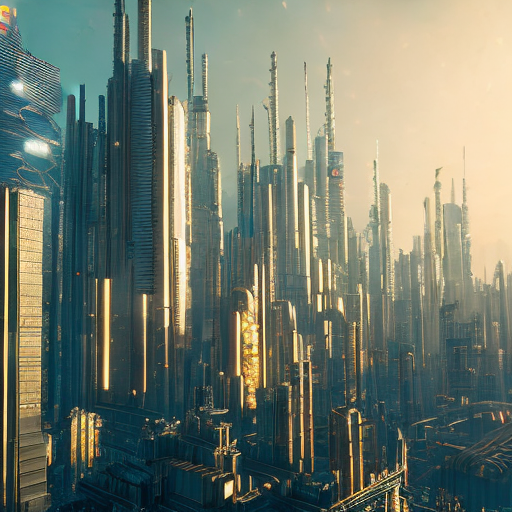

In [9]:
text = "\n\t".join(text_prompt.value.split("."))
print("Input text:")
print("\t" + text)
display(final_image)

Nice. As you can see, the picture has quite a high definition 🔥.

### Interactive text-to-image demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(pipe)

try:
    demo.queue().launch()
except Exception:
    demo.queue().launch(share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

In [ ]:
import gc

demo.close()
del pipe

gc.collect()

## Image-to-Image pipeline
[back to top ⬆️](#Table-of-contents:)

`openvino_genai.Image2ImagePipeline` represents inference pipeline for text-guided image-to-image generation. For creation pipeline instance, you should provide directory with converted to OpenVINO model and inference device.

As model components remains the same like for text-to-image generation, we can reuse models converted previously.

In [12]:
import requests

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [13]:
DEVICE = device.value

ov_pipe_i2i = ov_genai.Image2ImagePipeline(MODEL_DIR, device=DEVICE)

### Image-to-Image generation
[back to top ⬆️](#Table-of-contents:)

Image-to-Image generation, additionally to text prompt, requires providing initial image. Optionally, you can also change `strength` parameter, which is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 enable lots of variations but will also produce images that are not semantically consistent with the input.

In [19]:
text_prompt_i2i = widgets.Text(value="amazing watercolor painting", description="your text")
num_steps_i2i = widgets.IntSlider(min=1, max=50, value=10, description="steps:")
seed_i2i = widgets.IntSlider(min=0, max=1024, description="seed: ", value=42)
image_widget = widgets.FileUpload(
    accept="",
    multiple=False,
    description="Upload image",
)
strength = widgets.FloatSlider(min=0, max=1, description="strength: ", value=0.25)
widgets.VBox([text_prompt_i2i, seed_i2i, num_steps_i2i, image_widget, strength])

Pipeline settings
Input text: amazing watercolor painting
Seed: 42
Number of steps: 10
Strength: 0.3
Input image:


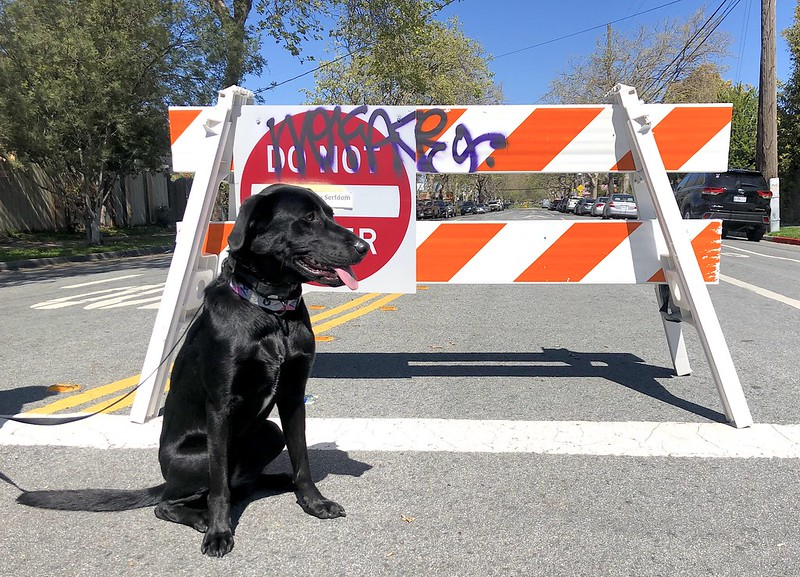

In [20]:
import io
import PIL

default_image_path = Path("coco.jpg")
if not default_image_path.exists():
    download_file(
        "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
        filename="coco.jpg",
    )

# read uploaded image
image = PIL.Image.open(io.BytesIO(image_widget.value[-1]["content"]) if image_widget.value else str(default_image_path))
print("Pipeline settings")
print(f"Input text: {text_prompt_i2i.value}")
print(f"Seed: {seed_i2i.value}")
print(f"Number of steps: {num_steps_i2i.value}")
print(f"Strength: {strength.value}")
print("Input image:")
display(image)

In [21]:
import openvino as ov
import numpy as np


def image_to_tensor(image: Image) -> ov.Tensor:
    pic = image.convert("RGB")
    image_data = np.array(pic.getdata()).reshape(1, pic.size[1], pic.size[0], 3).astype(np.uint8)
    return ov.Tensor(image_data)

In [22]:
image_tensor = image_to_tensor(image)

random_generator = ov_genai.TorchGenerator(seed.value)

pbar = tqdm(total=int(num_steps_i2i.value * strength.value) + 1)


def callback(step, num_steps, latent):
    if num_steps != pbar.total:
        pbar.reset(num_steps)
    pbar.update(1)
    sys.stdout.flush()
    return False


processed_image = ov_pipe_i2i.generate(
    text_prompt_i2i.value, image_tensor, num_inference_steps=num_steps_i2i.value, strength=strength.value, generator=random_generator, callback=callback
)

final_image_i2i = Image.fromarray(processed_image.data[0])

  0%|          | 0/4 [00:00<?, ?steps/s]

Input text:
	amazing watercolor painting


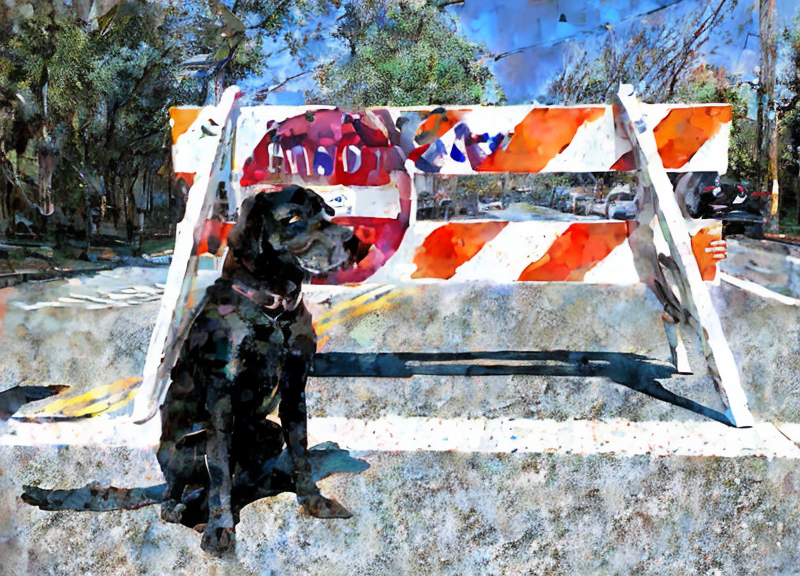

In [23]:
text_i2i = "\n\t".join(text_prompt_i2i.value.split("."))
print("Input text:")
print("\t" + text_i2i)
display(final_image_i2i)

### Interactive image-to-image demo
[back to top ⬆️](#Table-of-contents:)


In [ ]:
from gradio_helper import make_demo_i2i

demo = make_demo_i2i(ov_pipe_i2i, default_image_path)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/